# Import thư viện

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
import xgboost as xgb

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Dữ liệu

In [2]:
#Đọc dữ liệu vào dataframe
df = pd.read_csv("./gasoline_prices.csv")
df.head()

,date,RON 95-III,RON 92-II
0,8/22/2018,21.17,19.61
1,8/23/2018,21.17,19.61
2,8/24/2018,21.17,19.61
3,8/25/2018,21.17,19.61
4,8/26/2018,21.17,19.61


In [3]:
#Chuyển cột date trong df thành đối tượng datetime
df['date'] = pd.to_datetime(df['date'])

#Tạo df_gasolinePrices từ df với 'date', 'RON 95-III' và đặt 'date' làm index.
df_gasolinePrices = df.loc[::3, ['date', 'RON 95-III']]
df_gasolinePrices.set_index('date', inplace=True)
df_gasolinePrices.head()

,RON 95-III
date,
2018-08-22,21.17
2018-08-27,21.17
2018-09-01,21.17
2018-09-06,21.47
2018-09-11,21.47


### Chia dữ liệu thành tập train và test

In [4]:
# Số lượng điểm dữ liệu cho tập train và test
train_size = 0.8
test_size = (1 - train_size)

# Tính toán số lượng dòng cho tập train và test
train_split = int(len(df_gasolinePrices) * train_size)
test_split = int(len(df_gasolinePrices) * (train_size + test_size))

train = df_gasolinePrices[:train_split]
test = df_gasolinePrices[train_split:test_split]

# In ra kích thước của từng tập
print("Train:", len(train))
print("Test:", len(test))

Train: 305
Test: 77


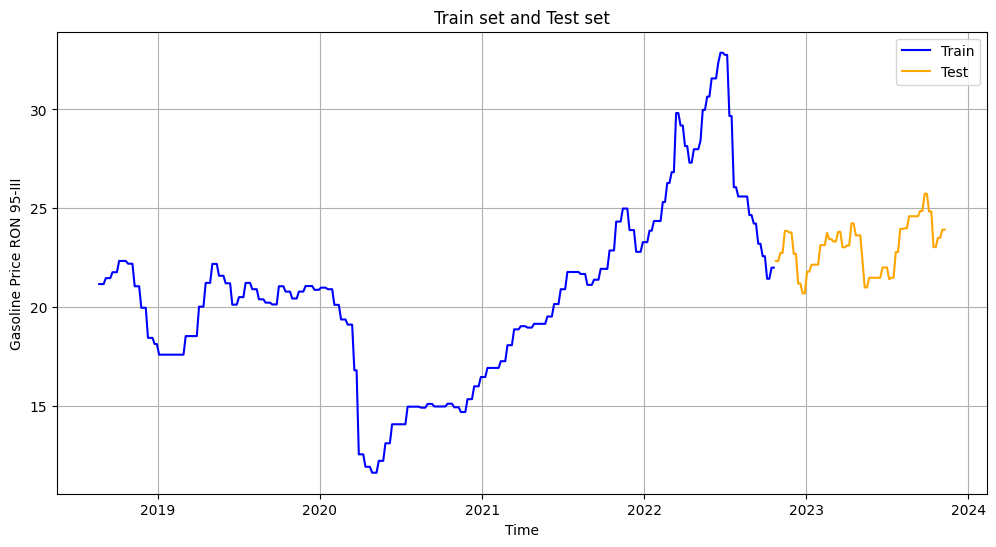

In [5]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE cho tập train và test
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth cho tập train
plt.plot(train['RON 95-III'], label='Train', color='blue')

# Vẽ đường ground truth cho tập test
plt.plot(test['RON 95-III'], label='Test', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Train set and Test set')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [6]:
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (305, 1)
Test data shape:  (77, 1)


### Chuẩn hóa dữ liệu

In [7]:
scaler = MinMaxScaler()


train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [8]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 10):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.squeeze(np.array(Xs), axis=-1), np.array(ys),
# Gia 12 thang
look_back = 20
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (293, 12)
y_train.shape:  (293, 1)
X_test.shape:  (65, 12)
y_test.shape:  (65, 1)


# XGboost

In [9]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

### Xây dựng mô hình XGboost

In [10]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=3, 
                             learning_rate=0.1, 
                             n_estimators=40, 
                            )


model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Dự đoán trên tập train (XGB)

In [11]:
y_train_pred_xgb = model_xgb.predict(X_train_xgb)
y_train_pred_xgb = scaler.inverse_transform(y_train_pred_xgb.reshape(-1, 1))
y_train_xgb = scaler.inverse_transform(y_train_xgb)

In [12]:
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_xgb, y_train_pred_xgb))
r2_train_xgb = r2_score(y_train_xgb, y_train_pred_xgb)

print("RMSE (XGB): ", rmse_train_xgb)
print("R-squared (XGB): ", r2_train_xgb)

RMSE (XGB):  0.38512560134628315
R-squared (XGB):  0.9926553792304451


### Dự đoán trên tập test (XGB)

In [13]:
y_test_pred_xgb = model_xgb.predict(X_test_xgb)
y_test_pred_xgb = scaler.inverse_transform(y_test_pred_xgb.reshape(-1, 1))
y_test_xgb = scaler.inverse_transform(y_test_xgb)

In [14]:
# Evaluate the model
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_test_pred_xgb))
r2_test_xgb = r2_score(y_test_xgb, y_test_pred_xgb)

print("RMSE (XGB): ", rmse_test_xgb)
print("R-squared (XGB): ", r2_test_xgb)

RMSE (XGB):  0.6032573069322564
R-squared (XGB):  0.7696476421292207


## Dự đoán giá xăng 30 ngày tiếp theo (XGB)

In [15]:
days = 10
timesteps = look_back + 1
df_gasolinePrices_pre = df_gasolinePrices.copy()
gasolinePrices_scaled = scaler.transform(df_gasolinePrices_pre)

# Lấy dữ liệu cuối cùng từ tập dữ liệu
last_data = gasolinePrices_scaled[-timesteps:]
last_data = last_data.reshape(1, -1)[:, -(timesteps-1):]

predicted_prices_xgb = []
for day in range(days):
    next_prediction = model_xgb.predict(last_data)
    last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
    predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
    predicted_prices_xgb.append(predicted_price[0, 0])
    
last_date = df_gasolinePrices_pre.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=3), periods=days, freq='3D')

predicted_df_xgb = pd.DataFrame(index=future_dates, columns=['RON 95-III'])

predicted_df_xgb['RON 95-III'] = predicted_prices_xgb

df_gasolinePrices_pre = pd.concat([df_gasolinePrices_pre, predicted_df_xgb], axis=0)

In [16]:
import pandas as pd

last_date = '11/12/2023'
future_dates = pd.date_range(start=last_date , periods=days, freq='3D')

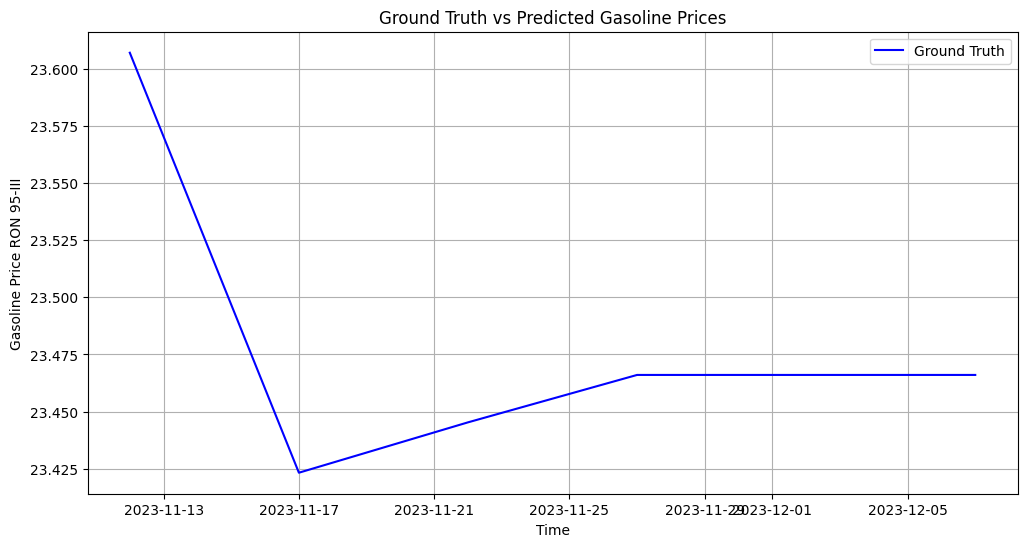

In [17]:
plt.figure(figsize=(12, 6))

plt.plot(predicted_df_xgb.index, predicted_df_xgb['RON 95-III'], label='Ground Truth', color='blue')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

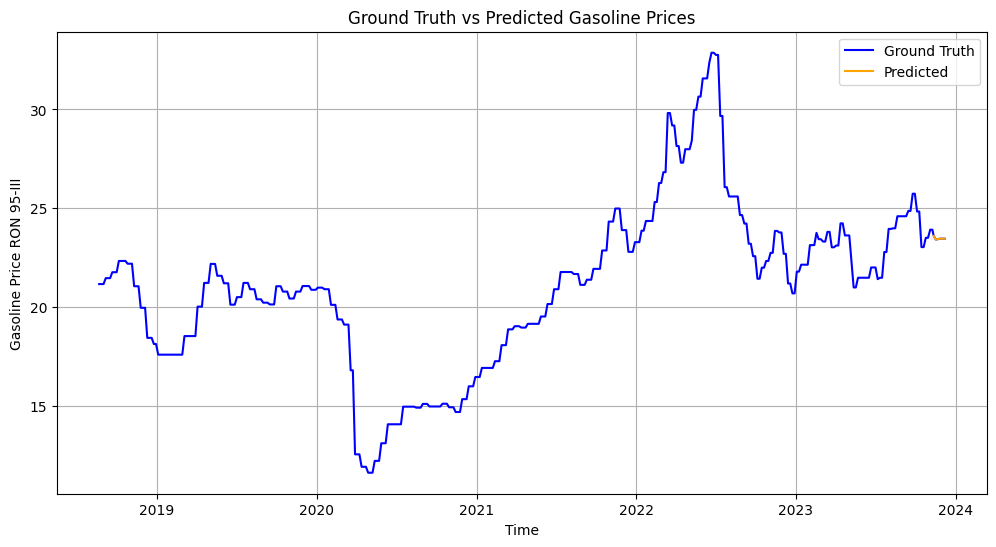

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(df_gasolinePrices_pre.index, df_gasolinePrices_pre['RON 95-III'], label='Ground Truth', color='blue')
plt.plot(predicted_df_xgb.index, predicted_df_xgb['RON 95-III'], label='Predicted', color='orange')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

# SVM

In [19]:
X_train_svm, y_train_svm = X_train, y_train
X_test_svm, y_test_svm = X_test, y_test

### Xây dựng model (SVM)

In [20]:
model_svm = SVR(C=5, kernel='rbf', gamma='auto', epsilon=0.01)

model_svm.fit(X_train_svm, y_train_svm)

C:\Users\haonh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=5, epsilon=0.01, gamma='auto')

### Dự đoán trên tập train (SVM)

In [21]:
y_train_pred_svm = model_svm.predict(X_train_svm)
y_train_pred_svm = scaler.inverse_transform(y_train_pred_svm.reshape(-1, 1))
y_train_svm = scaler.inverse_transform(y_train_svm)

In [22]:
rmse_train_svm = np.sqrt(mean_squared_error(y_train_svm, y_train_pred_svm))
r2_train_svm = r2_score(y_train_svm, y_train_pred_svm)

print("RMSE (SVM): ", rmse_train_svm)
print("R-squared (SVM): ", r2_train_svm)

RMSE (SVM):  0.538715950902857
R-squared (SVM):  0.9856290900787922


### Dự đoán trên tập test (SVM)

In [23]:
y_test_pred_svm = model_svm.predict(X_test_svm)
y_test_pred_svm = scaler.inverse_transform(y_test_pred_svm.reshape(-1, 1))
y_test_svm = scaler.inverse_transform(y_test_svm)

In [24]:
rmse_test_svm = np.sqrt(mean_squared_error(y_test_svm, y_test_pred_svm))
r2_test_svm = r2_score(y_test_svm, y_test_pred_svm)

print("RMSE (SVM): ", rmse_test_svm)
print("R-squared (SVM): ", r2_test_svm)

RMSE (SVM):  0.5810240942311485
R-squared (SVM):  0.7863141499987849


## Dự đoán giá xăng trong 30 ngày tiếp theo (SVM)

In [25]:
days = 10
timesteps = look_back + 1
df_gasolinePrices_pre = df_gasolinePrices.copy()
gasolinePrices_scaled = scaler.transform(df_gasolinePrices_pre)

# Lấy dữ liệu cuối cùng từ tập dữ liệu
last_data = gasolinePrices_scaled[-timesteps:]
last_data = last_data.reshape(1, -1)[:, -(timesteps-1):]

predicted_prices_svm = []
for day in range(days):
    next_prediction = model_svm.predict(last_data)
    last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
    predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
    predicted_prices_svm.append(predicted_price[0, 0])
    
last_date = df_gasolinePrices_pre.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=3), periods=days, freq='3D')

predicted_df_svm = pd.DataFrame(index=future_dates, columns=['RON 95-III'])

predicted_df_svm['RON 95-III'] = predicted_prices_svm

df_gasolinePrices_pre = pd.concat([df_gasolinePrices_pre, predicted_df_svm], axis=0)

In [26]:
import pandas as pd

last_date = '11/12/2023'
future_dates = pd.date_range(start=last_date , periods=days, freq='3D')

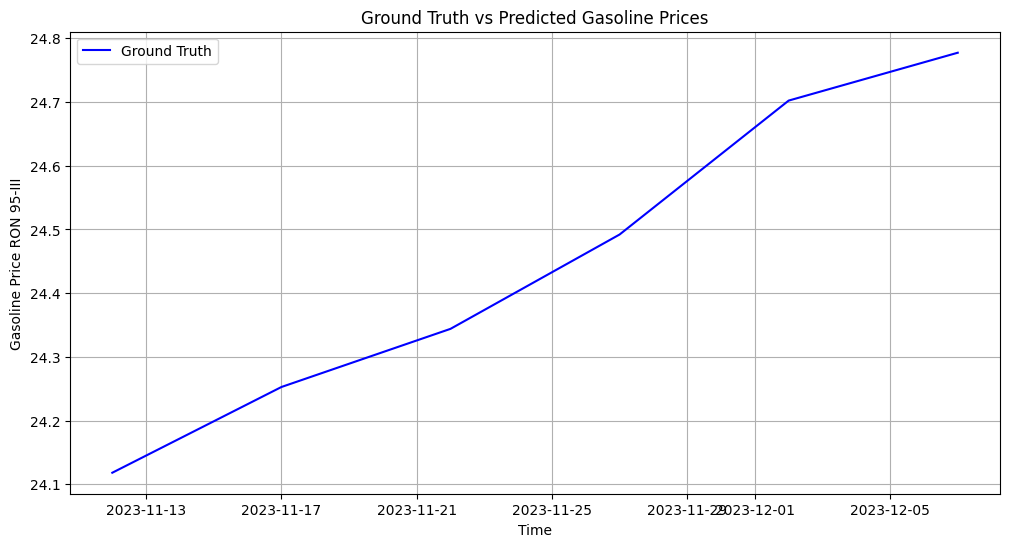

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(predicted_df_svm.index, predicted_df_svm['RON 95-III'], label='Ground Truth', color='blue')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

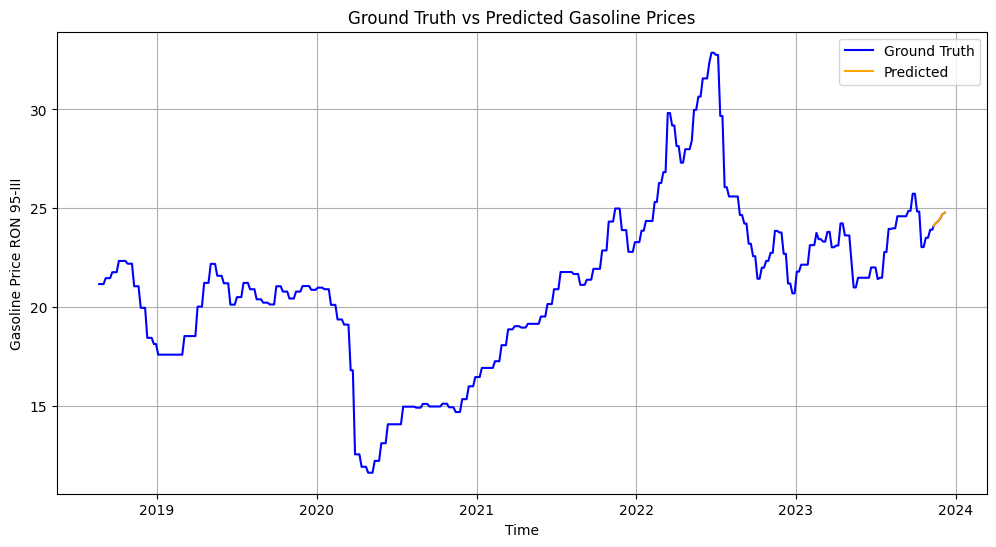

In [28]:
plt.figure(figsize=(12, 6))

plt.plot(df_gasolinePrices_pre.index, df_gasolinePrices_pre['RON 95-III'], label='Ground Truth', color='blue')
plt.plot(predicted_df_svm.index, predicted_df_svm['RON 95-III'], label='Predicted', color='orange')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

# Random Forest

In [29]:
X_train_rf, y_train_rf = X_train, y_train
X_test_rf, y_test_rf = X_test, y_test

### Xây dựng model (RF)

In [30]:
# Tạo và huấn luyện mô hình Random Forest
model_rf = RandomForestRegressor(n_estimators=60, max_depth=4)

model_rf.fit(X_train_rf, y_train_rf)

C:\Users\haonh\AppData\Local\Temp\ipykernel_9360\2899953142.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_rf, y_train_rf)


RandomForestRegressor(max_depth=4, n_estimators=60)

### Dự đoán trên tập train (RF)

In [31]:
y_train_pred_rf = model_rf.predict(X_train_rf)

y_train_pred_rf = scaler.inverse_transform(y_train_pred_rf.reshape(-1, 1))
y_train_rf = scaler.inverse_transform(y_train_rf)

In [32]:
rmse_train_rf = np.sqrt(mean_squared_error(y_train_rf, y_train_pred_rf))
r2_train_rf = r2_score(y_train_rf, y_train_pred_rf)

print("RMSE (XGB): ", rmse_train_rf)
print("R-squared (XGB): ", r2_train_rf)

RMSE (XGB):  0.46588451762991634
R-squared (XGB):  0.9892521609599608


### Dự đoán trên tập test (RF)

In [33]:
y_test_pred_rf = model_rf.predict(X_test_rf)

y_test_pred_rf = scaler.inverse_transform(y_test_pred_rf.reshape(-1, 1))
y_test_rf = scaler.inverse_transform(y_test_rf)

In [34]:
rmse_test_rf = np.sqrt(mean_squared_error(y_test_rf, y_test_pred_rf))
r2_test_rf = r2_score(y_test_rf, y_test_pred_rf)

print("RMSE (XGB): ", rmse_test_rf)
print("R-squared (XGB): ", r2_test_rf)

RMSE (XGB):  0.5370534821231147
R-squared (XGB):  0.8174328846206408


## Dự đoán giá

In [35]:
days = 10
timesteps = look_back + 1
df_gasolinePrices_pre = df_gasolinePrices.copy()
gasolinePrices_scaled = scaler.transform(df_gasolinePrices_pre)

# Lấy dữ liệu cuối cùng từ tập dữ liệu
last_data = gasolinePrices_scaled[-timesteps:]
last_data = last_data.reshape(1, -1)[:, -(timesteps-1):]

predicted_prices_rf = []
for day in range(days):
    next_prediction = model_rf.predict(last_data)
    last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
    predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
    predicted_prices_rf.append(predicted_price[0, 0])
    
last_date = df_gasolinePrices_pre.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=3), periods=days, freq='3D')

predicted_df_rf = pd.DataFrame(index=future_dates, columns=['RON 95-III'])

predicted_df_rf['RON 95-III'] = predicted_prices_rf

df_gasolinePrices_pre = pd.concat([df_gasolinePrices_pre, predicted_df_rf], axis=0)

In [36]:
import pandas as pd

last_date = '11/12/2023'
future_dates = pd.date_range(start=last_date, periods=10, freq='3D')
future_dates

DatetimeIndex(['2023-11-12', '2023-11-15', '2023-11-18', '2023-11-21',
               '2023-11-24', '2023-11-27', '2023-11-30', '2023-12-03',
               '2023-12-06', '2023-12-09'],
              dtype='datetime64[ns]', freq='3D')

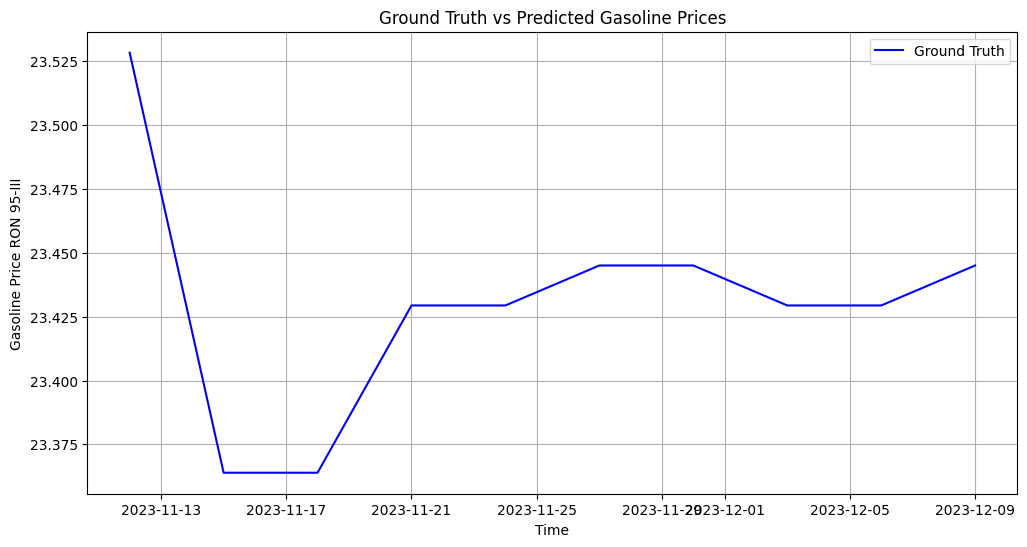

In [37]:
plt.figure(figsize=(12, 6))

plt.plot(predicted_df_rf.index, predicted_df_rf['RON 95-III'], label='Ground Truth', color='blue')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

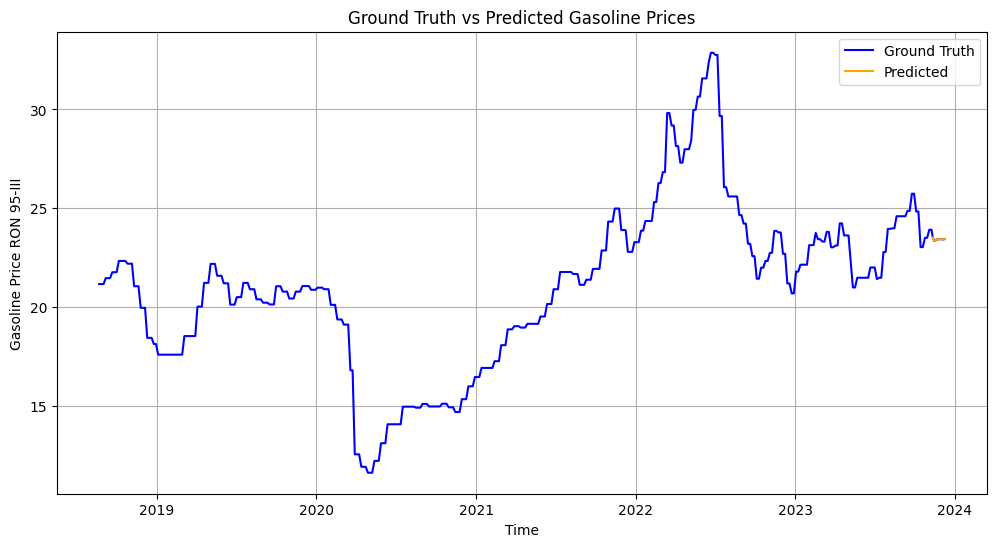

In [38]:
plt.figure(figsize=(12, 6))

plt.plot(df_gasolinePrices_pre.index, df_gasolinePrices_pre['RON 95-III'], label='Ground Truth', color='blue')
plt.plot(predicted_df_rf.index, predicted_df_rf['RON 95-III'], label='Predicted', color='orange')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()